In [1]:
import numpy as np; np.random.seed(0)
import tensorflow as tf; tf.set_random_seed(seed=0)
import pandas as pd
import lightgbm as lgb
import gc
from collections import defaultdict
import matplotlib
from tqdm import tqdm

In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]
target = train.target.values
#feature_cols = feature_cols[:2]

In [3]:
def transform_freq_feature(df1,df2,df3_base,feat):
    val1=df1[feat].values
    val2=df3_base[feat].values
    
    defa1=defaultdict(lambda:0)
    
    for val in val1:
        defa1[str(val)]+=1.
    for val in val2:
        defa1[str(val)]+=1.  
        
    df1[feat +"_freq"]= df1[feat].apply(lambda x :defa1[str(x)] ) 
    df2[feat+"_freq"]= df2[feat].apply(lambda x :defa1[str(x)] )  
    
def load_data():
    train_df = train[feature_cols].copy()
    test_df = test[feature_cols].copy()
    real_test_df = test[feature_cols].copy()

    unique_samples = []
    unique_count = np.zeros_like(test_df)
    for feature in tqdm(range(test_df.shape[1])):
        _, index_, count_ = np.unique(test_df.values[:, feature], return_counts=True, return_index=True)
        unique_count[index_[count_ == 1], feature] += 1
    
    # Samples which have unique values are real the others are fake
    real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
    synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]
    
    real_test_df=real_test_df.iloc[real_samples_indexes]
    print(real_test_df.shape[0])
    print(len(synthetic_samples_indexes))
    
    columns=train_df.columns.values
    for col in tqdm(columns):
        transform_freq_feature(train_df,test_df,real_test_df,col)
    '''
    from sklearn.preprocessing import MinMaxScaler
    
    for f in tqdm(columns):
        qt = MinMaxScaler(feature_range=(-3, 3)) #QuantileTransformer(output_distribution='normal')
        qt.fit(train_df[f].append(test_df[f]).values.reshape((-1,1)))
        train_df[f] = qt.transform(train_df[[f]].values).reshape((-1,))
        test_df[f] = qt.transform(test_df[[f]].values).reshape((-1,))
        
    for f in tqdm(columns):
        train_df[f+'_exp'] = np.where(train_df[f+'_freq']>1, 2, 1)**train_df[f]
        test_df[f+'_exp'] = np.where(test_df[f+'_freq']>1, 2, 1)**test_df[f]
    
    for f in tqdm(columns):
        train_df[f+'_exp2'] = train_df[f]*np.log1p(train_df[f+'_freq'])
        test_df[f+'_exp2'] = test_df[f]*np.log1p(test_df[f+'_freq'])
    '''    
    return train_df.fillna(-1), test_df.fillna(-1), real_samples_indexes 

train_df, test_df, real_samples_indexes = load_data()

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.81it/s]


100000
100000


100%|████████████████████████████████████████████████████████████████████████████| 200/200 [02:26<00:00,  1.06s/it]


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
def sample(train_df, feat, min_max_range, target):
    train_ori = MinMaxScaler(feature_range=min_max_range).fit_transform(train_df[[feat]].values).reshape((-1,))
    train_exp = (np.where(train_df[feat+'_freq']>1, 2, 1)**train_ori).reshape((-1,1))
    train_ori = train_df[[feat]].values #StandardScaler().fit_transform(train_df[[feat]].values)
    train_freq = train_df[[feat+'_freq']].values #StandardScaler().fit_transform(train_df[[feat+'_freq']].values)
    tr = np.hstack([train_ori, train_freq, train_exp])
    
    aucs = []
    oof = np.zeros((train_df.shape[0]), dtype=np.float32)
    n_fold = 4
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)

    for fold_n, (train_index, valid_index) in enumerate(folds.split(train.target.values,train.target.values)):
    
        X_train, X_valid = tr[train_index, :], tr[valid_index, :]
        y_train, y_valid = target[train_index], target[valid_index]
    
        lr = LogisticRegression(solver='liblinear')
        lr.fit(X_train, y_train)
        val_pred = lr.predict_proba(X_valid)[:,1]
        aucs.append(roc_auc_score(y_valid, val_pred))
        
        oof[valid_index] = val_pred
        
    return np.mean(aucs), np.std(aucs)

In [5]:
res = pd.DataFrame(columns=['features', 'best auc', 'best min max range'])

for f_i, f in enumerate(feature_cols):
    best_auc = None
    best_range = None
    
    for bias in tqdm(np.arange(-6., 6.1, 0.5)):
        min_max_range = (-3+bias, 3+bias)
        auc_m, auc_s = sample(train_df, f, min_max_range, target)
        if best_auc is None or auc_m > best_auc:
            best_range = min_max_range
            best_auc = auc_m
            
    print('{} best averaged auc: {:.4f} with range: '.format(f, best_auc), best_range)
    res.loc[f_i] = [f, best_auc, best_range]

100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.23s/it]


var_0 best averaged auc: 0.5477 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.30s/it]


var_1 best averaged auc: 0.5447 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.22s/it]


var_2 best averaged auc: 0.5480 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.32s/it]


var_3 best averaged auc: 0.5101 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.15s/it]


var_4 best averaged auc: 0.5093 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.20s/it]


var_5 best averaged auc: 0.5286 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.30s/it]


var_6 best averaged auc: 0.5601 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.16s/it]


var_7 best averaged auc: 0.5040 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.16s/it]


var_8 best averaged auc: 0.5186 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.14s/it]


var_9 best averaged auc: 0.5367 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.17s/it]


var_10 best averaged auc: 0.4994 with range:  (0.0, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.20s/it]


var_11 best averaged auc: 0.5207 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.23it/s]


var_12 best averaged auc: 0.5584 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.27s/it]


var_13 best averaged auc: 0.5485 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.20s/it]


var_14 best averaged auc: 0.5048 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


var_15 best averaged auc: 0.5156 with range:  (0.0, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.25s/it]


var_16 best averaged auc: 0.5075 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.30s/it]


var_17 best averaged auc: 0.4989 with range:  (-1.5, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:29<00:00,  1.33s/it]


var_18 best averaged auc: 0.5381 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.39s/it]


var_19 best averaged auc: 0.5097 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.30s/it]


var_20 best averaged auc: 0.5172 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.18s/it]


var_21 best averaged auc: 0.5561 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.20s/it]


var_22 best averaged auc: 0.5527 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.15s/it]


var_23 best averaged auc: 0.5230 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.29s/it]


var_24 best averaged auc: 0.5261 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.34it/s]


var_25 best averaged auc: 0.5105 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.20s/it]


var_26 best averaged auc: 0.5566 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.29s/it]


var_27 best averaged auc: 0.4954 with range:  (-5.5, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.19s/it]


var_28 best averaged auc: 0.5224 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.28s/it]


var_29 best averaged auc: 0.5040 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.07s/it]


var_30 best averaged auc: 0.5030 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.10s/it]


var_31 best averaged auc: 0.5258 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.17s/it]


var_32 best averaged auc: 0.5271 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.15s/it]


var_33 best averaged auc: 0.5397 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.30it/s]


var_34 best averaged auc: 0.5467 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.13s/it]


var_35 best averaged auc: 0.5353 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.14s/it]


var_36 best averaged auc: 0.5364 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.24s/it]


var_37 best averaged auc: 0.5048 with range:  (-1.5, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.25s/it]


var_38 best averaged auc: 0.5016 with range:  (-1.5, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.15s/it]


var_39 best averaged auc: 0.5029 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.06s/it]


var_40 best averaged auc: 0.5447 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.29s/it]


var_41 best averaged auc: 0.5038 with range:  (-6.0, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.11it/s]


var_42 best averaged auc: 0.5081 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.36it/s]


var_43 best averaged auc: 0.5255 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.18s/it]


var_44 best averaged auc: 0.5412 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.21s/it]


var_45 best averaged auc: 0.5179 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.21s/it]


var_46 best averaged auc: 0.5025 with range:  (3.0, 9.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.10s/it]


var_47 best averaged auc: 0.5076 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.25s/it]


var_48 best averaged auc: 0.5331 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.13s/it]


var_49 best averaged auc: 0.5273 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.29it/s]


var_50 best averaged auc: 0.5138 with range:  (1.0, 7.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.20s/it]


var_51 best averaged auc: 0.5235 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13s/it]


var_52 best averaged auc: 0.5286 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.21s/it]


var_53 best averaged auc: 0.5541 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13s/it]


var_54 best averaged auc: 0.5180 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.20s/it]


var_55 best averaged auc: 0.5153 with range:  (-5.5, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.06s/it]


var_56 best averaged auc: 0.5304 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.09s/it]


var_57 best averaged auc: 0.5147 with range:  (-7.5, -1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.08s/it]


var_58 best averaged auc: 0.5255 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.04s/it]


var_59 best averaged auc: 0.5083 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.24s/it]


var_60 best averaged auc: 0.5079 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.03s/it]


var_61 best averaged auc: 0.5071 with range:  (-6.0, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.08s/it]


var_62 best averaged auc: 0.5116 with range:  (-7.5, -1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.11s/it]


var_63 best averaged auc: 0.5129 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.16s/it]


var_64 best averaged auc: 0.5116 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.09s/it]


var_65 best averaged auc: 0.5110 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.22s/it]


var_66 best averaged auc: 0.5216 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.22s/it]


var_67 best averaged auc: 0.5444 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.05s/it]


var_68 best averaged auc: 0.5106 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.12s/it]


var_69 best averaged auc: 0.5100 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.18s/it]


var_70 best averaged auc: 0.5250 with range:  (-1.5, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.08it/s]


var_71 best averaged auc: 0.5311 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.14s/it]


var_72 best averaged auc: 0.5130 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.14s/it]


var_73 best averaged auc: 0.5038 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.14s/it]


var_74 best averaged auc: 0.5212 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.08s/it]


var_75 best averaged auc: 0.5360 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13s/it]


var_76 best averaged auc: 0.5575 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.05s/it]


var_77 best averaged auc: 0.5154 with range:  (-6.0, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.16s/it]


var_78 best averaged auc: 0.5423 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.00s/it]


var_79 best averaged auc: 0.5054 with range:  (-6.5, -0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13s/it]


var_80 best averaged auc: 0.5509 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.07it/s]


var_81 best averaged auc: 0.5705 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.50s/it]


var_82 best averaged auc: 0.5208 with range:  (-1.0, 5.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.20s/it]


var_83 best averaged auc: 0.5203 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.22s/it]


var_84 best averaged auc: 0.5110 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.09s/it]


var_85 best averaged auc: 0.5230 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.13s/it]


var_86 best averaged auc: 0.5367 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.27s/it]


var_87 best averaged auc: 0.5353 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.17s/it]


var_88 best averaged auc: 0.5193 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.30s/it]


var_89 best averaged auc: 0.5350 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.13s/it]


var_90 best averaged auc: 0.5273 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.10it/s]


var_91 best averaged auc: 0.5354 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.27s/it]


var_92 best averaged auc: 0.5430 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.29it/s]


var_93 best averaged auc: 0.5306 with range:  (-5.5, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.20s/it]


var_94 best averaged auc: 0.5418 with range:  (-5.5, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.28s/it]


var_95 best averaged auc: 0.5328 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.21s/it]


var_96 best averaged auc: 0.5016 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.23s/it]


var_97 best averaged auc: 0.5148 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.12s/it]


var_98 best averaged auc: 0.5054 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.22s/it]


var_99 best averaged auc: 0.5525 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.15s/it]


var_100 best averaged auc: 0.5001 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.25s/it]


var_101 best averaged auc: 0.5082 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.25s/it]


var_102 best averaged auc: 0.5197 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.01it/s]


var_103 best averaged auc: 0.5015 with range:  (3.0, 9.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.18s/it]


var_104 best averaged auc: 0.5262 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.36s/it]


var_105 best averaged auc: 0.5242 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.22s/it]


var_106 best averaged auc: 0.5299 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.23s/it]


var_107 best averaged auc: 0.5389 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.16it/s]


var_108 best averaged auc: 0.5438 with range:  (-7.0, -1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.03s/it]


var_109 best averaged auc: 0.5429 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.27s/it]


var_110 best averaged auc: 0.5590 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.33s/it]


var_111 best averaged auc: 0.5232 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.20s/it]


var_112 best averaged auc: 0.5219 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.26s/it]


var_113 best averaged auc: 0.5132 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.27s/it]


var_114 best averaged auc: 0.5228 with range:  (1.5, 7.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.22s/it]


var_115 best averaged auc: 0.5454 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.11s/it]


var_116 best averaged auc: 0.5221 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.25s/it]


var_117 best averaged auc: 0.5037 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.15s/it]


var_118 best averaged auc: 0.5406 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.24s/it]


var_119 best averaged auc: 0.5272 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.18s/it]


var_120 best averaged auc: 0.5147 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.18s/it]


var_121 best averaged auc: 0.5355 with range:  (1.0, 7.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.18s/it]


var_122 best averaged auc: 0.5388 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.23s/it]


var_123 best averaged auc: 0.5374 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.17s/it]


var_124 best averaged auc: 0.5047 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.28it/s]


var_125 best averaged auc: 0.5239 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.05it/s]


var_126 best averaged auc: 0.5028 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.18s/it]


var_127 best averaged auc: 0.5363 with range:  (-1.5, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.20s/it]


var_128 best averaged auc: 0.5235 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.29s/it]


var_129 best averaged auc: 0.5039 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.14s/it]


var_130 best averaged auc: 0.5268 with range:  (-6.0, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.14s/it]


var_131 best averaged auc: 0.5293 with range:  (0.0, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.18s/it]


var_132 best averaged auc: 0.5220 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.03it/s]


var_133 best averaged auc: 0.5470 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.16s/it]


var_134 best averaged auc: 0.5159 with range:  (-1.5, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.15s/it]


var_135 best averaged auc: 0.5249 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.16s/it]


var_136 best averaged auc: 0.5027 with range:  (-0.5, 5.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.23s/it]


var_137 best averaged auc: 0.5246 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.12s/it]


var_138 best averaged auc: 0.5196 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.22s/it]


var_139 best averaged auc: 0.5693 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.09s/it]


var_140 best averaged auc: 0.5143 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.10s/it]


var_141 best averaged auc: 0.5269 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.21s/it]


var_142 best averaged auc: 0.5192 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.09s/it]


var_143 best averaged auc: 0.5097 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.09s/it]


var_144 best averaged auc: 0.5205 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.20s/it]


var_145 best averaged auc: 0.5277 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.05s/it]


var_146 best averaged auc: 0.5556 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.18s/it]


var_147 best averaged auc: 0.5393 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.06it/s]


var_148 best averaged auc: 0.5496 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.21s/it]


var_149 best averaged auc: 0.5491 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.02it/s]


var_150 best averaged auc: 0.5235 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.25s/it]


var_151 best averaged auc: 0.5251 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.15s/it]


var_152 best averaged auc: 0.5090 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.04s/it]


var_153 best averaged auc: 0.5048 with range:  (-6.5, -0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.15s/it]


var_154 best averaged auc: 0.5428 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.22s/it]


var_155 best averaged auc: 0.5339 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.21it/s]


var_156 best averaged auc: 0.5192 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.11s/it]


var_157 best averaged auc: 0.5304 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.24s/it]


var_158 best averaged auc: 0.5033 with range:  (0.0, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.24s/it]


var_159 best averaged auc: 0.5154 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.11s/it]


var_160 best averaged auc: 0.5062 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.15it/s]


var_161 best averaged auc: 0.5027 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.24s/it]


var_162 best averaged auc: 0.5302 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.21s/it]


var_163 best averaged auc: 0.5299 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.20s/it]


var_164 best averaged auc: 0.5366 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.05s/it]


var_165 best averaged auc: 0.5516 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.08it/s]


var_166 best averaged auc: 0.5505 with range:  (-5.0, 1.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.18s/it]


var_167 best averaged auc: 0.5316 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.19s/it]


var_168 best averaged auc: 0.5121 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.09it/s]


var_169 best averaged auc: 0.5446 with range:  (0.5, 6.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.16s/it]


var_170 best averaged auc: 0.5415 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.18s/it]


var_171 best averaged auc: 0.5139 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.12s/it]


var_172 best averaged auc: 0.5387 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.18s/it]


var_173 best averaged auc: 0.5386 with range:  (-9.0, -3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.13s/it]


var_174 best averaged auc: 0.5541 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.16s/it]


var_175 best averaged auc: 0.5182 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.17s/it]


var_176 best averaged auc: 0.5081 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.05s/it]


var_177 best averaged auc: 0.5330 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.14s/it]


var_178 best averaged auc: 0.5198 with range:  (0.0, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.16s/it]


var_179 best averaged auc: 0.5418 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.20s/it]


var_180 best averaged auc: 0.5276 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.15s/it]


var_181 best averaged auc: 0.5121 with range:  (-5.5, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.21s/it]


var_182 best averaged auc: 0.5088 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.32s/it]


var_183 best averaged auc: 0.5051 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.28s/it]


var_184 best averaged auc: 0.5461 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.16s/it]


var_185 best averaged auc: 0.4937 with range:  (2.0, 8.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.36s/it]


var_186 best averaged auc: 0.5290 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:26<00:00,  1.20s/it]


var_187 best averaged auc: 0.5129 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.10s/it]


var_188 best averaged auc: 0.5306 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.21s/it]


var_189 best averaged auc: 0.5093 with range:  (-8.5, -2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.22s/it]


var_190 best averaged auc: 0.5515 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.35s/it]


var_191 best averaged auc: 0.5430 with range:  (-4.5, 1.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.13s/it]


var_192 best averaged auc: 0.5430 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.19s/it]


var_193 best averaged auc: 0.5162 with range:  (-2.5, 3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.13s/it]


var_194 best averaged auc: 0.5200 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.26s/it]


var_195 best averaged auc: 0.5253 with range:  (-5.5, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:23<00:00,  1.21s/it]


var_196 best averaged auc: 0.5217 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.01it/s]


var_197 best averaged auc: 0.5296 with range:  (-4.0, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.07s/it]


var_198 best averaged auc: 0.5466 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.22s/it]


var_199 best averaged auc: 0.5245 with range:  (-4.0, 2.0)


In [6]:
res_2 = pd.DataFrame(columns=['features', 'best auc', 'best min max range'])

for f_i, f in enumerate(feature_cols):
    best_auc = None
    best_range = None
    
    start_range = res.loc[f_i][2]
    
    for bias in tqdm(np.arange(-1., 1.1, 0.1)):
        min_max_range = (start_range[0]+bias, start_range[1]+bias)
        auc_m, auc_s = sample(train_df, f, min_max_range, target)
        if best_auc is None or auc_m > best_auc:
            best_range = min_max_range
            best_auc = auc_m
            
    print('{} best averaged auc: {:.4f} with range: '.format(f, best_auc), best_range)
    res_2.loc[f_i] = [f, best_auc, best_range]

100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.03s/it]


var_0 best averaged auc: 0.5477 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.03it/s]


var_1 best averaged auc: 0.5447 with range:  (-5.0, 0.9999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.06s/it]


var_2 best averaged auc: 0.5483 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.02it/s]


var_3 best averaged auc: 0.5101 with range:  (-4.6000000000000005, 1.3999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.01s/it]


var_4 best averaged auc: 0.5094 with range:  (-4.7, 1.2999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.02s/it]


var_5 best averaged auc: 0.5287 with range:  (-4.800000000000001, 1.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.20s/it]


var_6 best averaged auc: 0.5602 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.06s/it]


var_7 best averaged auc: 0.5044 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.06it/s]


var_8 best averaged auc: 0.5186 with range:  (-4.6000000000000005, 1.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01s/it]


var_9 best averaged auc: 0.5367 with range:  (-4.800000000000001, 1.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.06s/it]


var_10 best averaged auc: 0.4994 with range:  (-2.220446049250313e-16, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.13it/s]


var_11 best averaged auc: 0.5207 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.06s/it]


var_12 best averaged auc: 0.5586 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.15it/s]


var_13 best averaged auc: 0.5485 with range:  (-3.9000000000000004, 2.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.12it/s]


var_14 best averaged auc: 0.5049 with range:  (-3.7, 2.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:13<00:00,  1.48it/s]


var_15 best averaged auc: 0.5156 with range:  (-0.20000000000000018, 5.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.04it/s]


var_16 best averaged auc: 0.5075 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.04it/s]


var_17 best averaged auc: 0.4989 with range:  (-1.7000000000000002, 4.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


var_18 best averaged auc: 0.5381 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:23<00:00,  1.07s/it]


var_19 best averaged auc: 0.5097 with range:  (-5.0, 0.9999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.08s/it]


var_20 best averaged auc: 0.5172 with range:  (-1.9000000000000004, 4.1)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.06s/it]


var_21 best averaged auc: 0.5562 with range:  (-2.8000000000000003, 3.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.03it/s]


var_22 best averaged auc: 0.5527 with range:  (-3.9000000000000004, 2.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01s/it]


var_23 best averaged auc: 0.5230 with range:  (-4.300000000000001, 1.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.08s/it]


var_24 best averaged auc: 0.5261 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.37it/s]


var_25 best averaged auc: 0.5106 with range:  (-4.1000000000000005, 1.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.08it/s]


var_26 best averaged auc: 0.5566 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.09it/s]


var_27 best averaged auc: 0.4954 with range:  (-5.4, 0.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.09it/s]


var_28 best averaged auc: 0.5225 with range:  (-4.4, 1.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.10it/s]


var_29 best averaged auc: 0.5040 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.12it/s]


var_30 best averaged auc: 0.5030 with range:  (-4.9, 1.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01it/s]


var_31 best averaged auc: 0.5258 with range:  (-2.6, 3.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.20it/s]


var_32 best averaged auc: 0.5272 with range:  (-9.9, -3.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.06it/s]


var_33 best averaged auc: 0.5397 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04it/s]


var_34 best averaged auc: 0.5467 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.14it/s]


var_35 best averaged auc: 0.5353 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.14it/s]


var_36 best averaged auc: 0.5364 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.01s/it]


var_37 best averaged auc: 0.5049 with range:  (-0.7000000000000004, 5.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.05s/it]


var_38 best averaged auc: 0.5016 with range:  (-1.5000000000000002, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.11it/s]


var_39 best averaged auc: 0.5030 with range:  (-9.5, -3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.16it/s]


var_40 best averaged auc: 0.5448 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01s/it]


var_41 best averaged auc: 0.5039 with range:  (-5.800000000000001, 0.19999999999999973)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


var_42 best averaged auc: 0.5083 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.23it/s]


var_43 best averaged auc: 0.5255 with range:  (2.6999999999999997, 8.7)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.11it/s]


var_44 best averaged auc: 0.5413 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.26it/s]


var_45 best averaged auc: 0.5179 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.27s/it]


var_46 best averaged auc: 0.5026 with range:  (3.0999999999999996, 9.1)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.11it/s]


var_47 best averaged auc: 0.5076 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02it/s]


var_48 best averaged auc: 0.5331 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.00it/s]


var_49 best averaged auc: 0.5273 with range:  (-2.4000000000000004, 3.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.33it/s]


var_50 best averaged auc: 0.5138 with range:  (1.0999999999999996, 7.1)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.03s/it]


var_51 best averaged auc: 0.5236 with range:  (-4.300000000000001, 1.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_52 best averaged auc: 0.5286 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.07it/s]


var_53 best averaged auc: 0.5541 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.23it/s]


var_54 best averaged auc: 0.5183 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.04s/it]


var_55 best averaged auc: 0.5153 with range:  (-5.6000000000000005, 0.3999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.04it/s]


var_56 best averaged auc: 0.5304 with range:  (-5.1000000000000005, 0.8999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.13it/s]


var_57 best averaged auc: 0.5147 with range:  (-7.8, -1.8000000000000003)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.20it/s]


var_58 best averaged auc: 0.5256 with range:  (-3.2, 2.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:23<00:00,  1.16s/it]


var_59 best averaged auc: 0.5083 with range:  (2.5999999999999996, 8.6)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02s/it]


var_60 best averaged auc: 0.5080 with range:  (-4.7, 1.2999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.03it/s]


var_61 best averaged auc: 0.5071 with range:  (-6.1000000000000005, -0.1000000000000002)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


var_62 best averaged auc: 0.5116 with range:  (-7.5, -1.5000000000000002)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_63 best averaged auc: 0.5129 with range:  (-2.3000000000000003, 3.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.01s/it]


var_64 best averaged auc: 0.5117 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_65 best averaged auc: 0.5110 with range:  (-2.3000000000000003, 3.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.08s/it]


var_66 best averaged auc: 0.5216 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01it/s]


var_67 best averaged auc: 0.5444 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.10it/s]


var_68 best averaged auc: 0.5106 with range:  (-4.0, 1.9999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.16it/s]


var_69 best averaged auc: 0.5101 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.03s/it]


var_70 best averaged auc: 0.5250 with range:  (-1.5000000000000002, 4.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.04s/it]


var_71 best averaged auc: 0.5311 with range:  (-2.4000000000000004, 3.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_72 best averaged auc: 0.5130 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02s/it]


var_73 best averaged auc: 0.5038 with range:  (-4.8, 1.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02it/s]


var_74 best averaged auc: 0.5213 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.09it/s]


var_75 best averaged auc: 0.5361 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_76 best averaged auc: 0.5576 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.13it/s]


var_77 best averaged auc: 0.5154 with range:  (-6.0, -2.220446049250313e-16)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.18it/s]


var_78 best averaged auc: 0.5423 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.13it/s]


var_79 best averaged auc: 0.5055 with range:  (-6.4, -0.40000000000000036)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.23it/s]


var_80 best averaged auc: 0.5509 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.39it/s]


var_81 best averaged auc: 0.5705 with range:  (-5.0, 0.9999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.06it/s]


var_82 best averaged auc: 0.5208 with range:  (-1.3000000000000003, 4.7)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.25it/s]


var_83 best averaged auc: 0.5203 with range:  (-2.6, 3.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.23it/s]


var_84 best averaged auc: 0.5110 with range:  (-2.3000000000000003, 3.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.04it/s]


var_85 best averaged auc: 0.5230 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


var_86 best averaged auc: 0.5367 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.01it/s]


var_87 best averaged auc: 0.5353 with range:  (-2.4000000000000004, 3.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.09it/s]


var_88 best averaged auc: 0.5194 with range:  (-3.2, 2.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.13it/s]


var_89 best averaged auc: 0.5350 with range:  (-9.5, -3.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01it/s]


var_90 best averaged auc: 0.5273 with range:  (-4.6000000000000005, 1.3999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.33it/s]


var_91 best averaged auc: 0.5354 with range:  (-4.8, 1.2)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.13it/s]


var_92 best averaged auc: 0.5430 with range:  (-3.2, 2.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.72it/s]


var_93 best averaged auc: 0.5306 with range:  (-6.1, -0.10000000000000009)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.10it/s]


var_94 best averaged auc: 0.5418 with range:  (-5.4, 0.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_95 best averaged auc: 0.5328 with range:  (-9.3, -3.3000000000000003)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.03it/s]


var_96 best averaged auc: 0.5016 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.11s/it]


var_97 best averaged auc: 0.5149 with range:  (-4.300000000000001, 1.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.06it/s]


var_98 best averaged auc: 0.5054 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.05it/s]


var_99 best averaged auc: 0.5525 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.25it/s]


var_100 best averaged auc: 0.5001 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.07it/s]


var_101 best averaged auc: 0.5082 with range:  (-4.800000000000001, 1.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.17s/it]


var_102 best averaged auc: 0.5198 with range:  (-3.7, 2.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.02it/s]


var_103 best averaged auc: 0.5015 with range:  (2.5999999999999996, 8.6)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.00s/it]


var_104 best averaged auc: 0.5262 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.00s/it]


var_105 best averaged auc: 0.5242 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.00s/it]


var_106 best averaged auc: 0.5299 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.01it/s]


var_107 best averaged auc: 0.5389 with range:  (-2.6, 3.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


var_108 best averaged auc: 0.5438 with range:  (-7.0, -1.0000000000000002)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.08it/s]


var_109 best averaged auc: 0.5429 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.07it/s]


var_110 best averaged auc: 0.5590 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.08it/s]


var_111 best averaged auc: 0.5232 with range:  (-4.7, 1.2999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.24s/it]


var_112 best averaged auc: 0.5219 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.17it/s]


var_113 best averaged auc: 0.5132 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:23<00:00,  1.21s/it]


var_114 best averaged auc: 0.5228 with range:  (0.7999999999999999, 6.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.09it/s]


var_115 best averaged auc: 0.5454 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.09it/s]


var_116 best averaged auc: 0.5221 with range:  (-2.6, 3.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.00s/it]


var_117 best averaged auc: 0.5039 with range:  (-4.800000000000001, 1.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_118 best averaged auc: 0.5406 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


var_119 best averaged auc: 0.5272 with range:  (-4.6000000000000005, 1.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.05s/it]


var_120 best averaged auc: 0.5149 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.03s/it]


var_121 best averaged auc: 0.5355 with range:  (0.09999999999999998, 6.1)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_122 best averaged auc: 0.5388 with range:  (-2.4000000000000004, 3.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.20it/s]


var_123 best averaged auc: 0.5375 with range:  (-3.2, 2.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.19it/s]


var_124 best averaged auc: 0.5048 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.29it/s]


var_125 best averaged auc: 0.5239 with range:  (-4.6000000000000005, 1.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.11it/s]


var_126 best averaged auc: 0.5029 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.15it/s]


var_127 best averaged auc: 0.5363 with range:  (-1.4000000000000004, 4.6)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.11it/s]


var_128 best averaged auc: 0.5236 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.11it/s]


var_129 best averaged auc: 0.5041 with range:  (-4.7, 1.2999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.07s/it]


var_130 best averaged auc: 0.5268 with range:  (-5.800000000000001, 0.19999999999999973)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.02it/s]


var_131 best averaged auc: 0.5293 with range:  (0.09999999999999964, 6.1)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.24s/it]


var_132 best averaged auc: 0.5220 with range:  (2.5, 8.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.22it/s]


var_133 best averaged auc: 0.5470 with range:  (-4.4, 1.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.12it/s]


var_134 best averaged auc: 0.5160 with range:  (-1.8000000000000003, 4.2)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_135 best averaged auc: 0.5255 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.10s/it]


var_136 best averaged auc: 0.5027 with range:  (-0.5000000000000002, 5.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.05s/it]


var_137 best averaged auc: 0.5246 with range:  (-5.2, 0.7999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_138 best averaged auc: 0.5196 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


var_139 best averaged auc: 0.5694 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.24it/s]


var_140 best averaged auc: 0.5143 with range:  (-4.1000000000000005, 1.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.23it/s]


var_141 best averaged auc: 0.5269 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.02s/it]


var_142 best averaged auc: 0.5192 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.05s/it]


var_143 best averaged auc: 0.5097 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.10it/s]


var_144 best averaged auc: 0.5206 with range:  (-2.1, 3.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.11it/s]


var_145 best averaged auc: 0.5277 with range:  (-5.2, 0.7999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.09it/s]


var_146 best averaged auc: 0.5556 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_147 best averaged auc: 0.5393 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.07it/s]


var_148 best averaged auc: 0.5497 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.17it/s]


var_149 best averaged auc: 0.5491 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


var_150 best averaged auc: 0.5235 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.06it/s]


var_151 best averaged auc: 0.5251 with range:  (-3.0, 3.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.16it/s]


var_152 best averaged auc: 0.5091 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_153 best averaged auc: 0.5048 with range:  (-6.5, -0.5000000000000002)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.13it/s]


var_154 best averaged auc: 0.5428 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.15it/s]


var_155 best averaged auc: 0.5340 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.13it/s]


var_156 best averaged auc: 0.5193 with range:  (-4.2, 1.7999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.12it/s]


var_157 best averaged auc: 0.5306 with range:  (-3.7, 2.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.19s/it]


var_158 best averaged auc: 0.5033 with range:  (-2.220446049250313e-16, 6.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.32s/it]


var_159 best averaged auc: 0.5154 with range:  (3.0999999999999996, 9.1)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.07s/it]


var_160 best averaged auc: 0.5062 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.08it/s]


var_161 best averaged auc: 0.5029 with range:  (-10.0, -4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.10it/s]


var_162 best averaged auc: 0.5302 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.03s/it]


var_163 best averaged auc: 0.5301 with range:  (-3.2, 2.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.13it/s]


var_164 best averaged auc: 0.5366 with range:  (-5.0, 0.9999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.13it/s]


var_165 best averaged auc: 0.5516 with range:  (-3.5, 2.5)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.07it/s]


var_166 best averaged auc: 0.5505 with range:  (-4.9, 1.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.15it/s]


var_167 best averaged auc: 0.5316 with range:  (-4.4, 1.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.05it/s]


var_168 best averaged auc: 0.5122 with range:  (-4.1000000000000005, 1.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.23it/s]


var_169 best averaged auc: 0.5447 with range:  (0.3999999999999998, 6.3999999999999995)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.14it/s]


var_170 best averaged auc: 0.5416 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.18it/s]


var_171 best averaged auc: 0.5140 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.01s/it]


var_172 best averaged auc: 0.5388 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_173 best averaged auc: 0.5386 with range:  (-9.6, -3.6)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.03it/s]


var_174 best averaged auc: 0.5541 with range:  (-3.3000000000000003, 2.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.08it/s]


var_175 best averaged auc: 0.5183 with range:  (-3.8000000000000003, 2.1999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.39s/it]


var_176 best averaged auc: 0.5082 with range:  (2.4, 8.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.19s/it]


var_177 best averaged auc: 0.5330 with range:  (2.3, 8.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.03s/it]


var_178 best averaged auc: 0.5198 with range:  (-0.1000000000000002, 5.8999999999999995)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.05it/s]


var_179 best averaged auc: 0.5420 with range:  (-3.7, 2.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_180 best averaged auc: 0.5276 with range:  (-4.5, 1.4999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.06it/s]


var_181 best averaged auc: 0.5121 with range:  (-4.7, 1.2999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.29it/s]


var_182 best averaged auc: 0.5091 with range:  (-3.2, 2.8)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.01it/s]


var_183 best averaged auc: 0.5051 with range:  (-2.0, 4.0)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.00it/s]


var_184 best averaged auc: 0.5461 with range:  (-2.9000000000000004, 3.0999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:23<00:00,  1.19s/it]


var_185 best averaged auc: 0.4941 with range:  (2.3999999999999995, 8.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.18it/s]


var_186 best averaged auc: 0.5290 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.19it/s]


var_187 best averaged auc: 0.5130 with range:  (-4.2, 1.7999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.21it/s]


var_188 best averaged auc: 0.5306 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.23it/s]


var_189 best averaged auc: 0.5093 with range:  (-8.1, -2.1000000000000005)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.19it/s]


var_190 best averaged auc: 0.5515 with range:  (-3.6, 2.4)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:20<00:00,  1.02it/s]


var_191 best averaged auc: 0.5430 with range:  (-4.300000000000001, 1.6999999999999997)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.08it/s]


var_192 best averaged auc: 0.5430 with range:  (-3.1, 2.9)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.16it/s]


var_193 best averaged auc: 0.5163 with range:  (-2.7, 3.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:21<00:00,  1.13s/it]


var_194 best averaged auc: 0.5200 with range:  (-3.7, 2.3)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.15it/s]


var_195 best averaged auc: 0.5253 with range:  (-5.6000000000000005, 0.3999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.15it/s]


var_196 best averaged auc: 0.5218 with range:  (-1.8000000000000003, 4.199999999999999)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_197 best averaged auc: 0.5296 with range:  (-4.0, 1.9999999999999998)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.08it/s]


var_198 best averaged auc: 0.5466 with range:  (-3.4000000000000004, 2.5999999999999996)


100%|██████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.22it/s]


var_199 best averaged auc: 0.5245 with range:  (-4.1000000000000005, 1.9)


In [7]:
res_o = pd.DataFrame(columns=['features', 'best auc', 'best min max range'])

for f_i, f in tqdm(enumerate(feature_cols)):
    min_max_range = (-3, 3)
    auc_m, auc_s = sample(train_df, f, min_max_range, target)
    res_o.loc[f_i] = [f, auc_m, min_max_range]

200it [03:01,  1.16it/s]


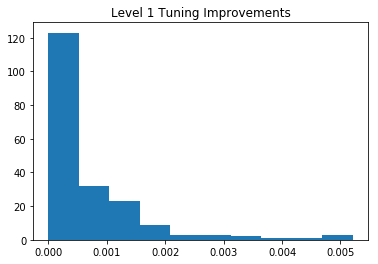

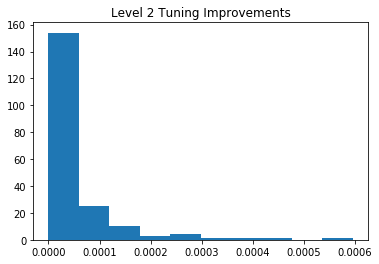

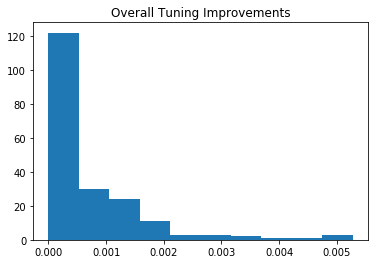

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Level 1 Tuning Improvements'); plt.hist(res['best auc']-res_o['best auc']); plt.show()
plt.title('Level 2 Tuning Improvements'); plt.hist(res_2['best auc']-res['best auc']); plt.show()
plt.title('Overall Tuning Improvements'); plt.hist(res_2['best auc']-res_o['best auc']); plt.show()

In [9]:
res.loc[res['best auc']-res_o['best auc']>0.003,]

,features,best auc,best min max range
12,var_12,0.558411,"(-9.0, -3.0)"
27,var_27,0.495383,"(-5.5, 0.5)"
30,var_30,0.502968,"(-5.0, 1.0)"
41,var_41,0.503809,"(-6.0, 0.0)"
130,var_130,0.526796,"(-6.0, 0.0)"
164,var_164,0.536584,"(-5.0, 1.0)"
167,var_167,0.531580,"(-4.5, 1.5)"


In [10]:
# genereate new tuned magic
magic_cols = [f+'_exp' for f in feature_cols]
train_magic_tuned = pd.DataFrame(columns=magic_cols)
test_magic_tuned = pd.DataFrame(columns=magic_cols)
train_magic = pd.DataFrame(columns=magic_cols)
test_magic = pd.DataFrame(columns=magic_cols)

for f_i, f in enumerate(tqdm(feature_cols)):
    mm = MinMaxScaler(feature_range=res_2.loc[f_i][2])
    train_ori = mm.fit_transform(train_df[[f]].values).reshape((-1,))
    train_magic_tuned[f+'_exp'] = np.where(train_df[f+'_freq']>1, 2, 1)**train_ori
    test_ori = mm.transform(test_df[[f]].values).reshape((-1,))
    test_magic_tuned[f+'_exp'] = np.where(test_df[f+'_freq']>1, 2, 1)**test_ori
    
    mm = MinMaxScaler(feature_range=(-3, 3))
    train_ori = mm.fit_transform(train_df[[f]].values).reshape((-1,))
    train_magic[f+'_exp'] = np.where(train_df[f+'_freq']>1, 2, 1)**train_ori
    test_ori = mm.transform(test_df[[f]].values).reshape((-1,))
    test_magic[f+'_exp'] = np.where(test_df[f+'_freq']>1, 2, 1)**test_ori

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [02:05<00:00,  1.60it/s]


In [11]:
train_magic_tuned.to_pickle('features/magic_tuned_train')
test_magic_tuned.to_pickle('features/magic_tuned_test')
train_magic.to_pickle('features/magic_train')
test_magic.to_pickle('features/magic_test')